# Weed & Rose Detection with Ultralytics YOLOv8s-seg
This notebook trains a YOLOv8s-seg model to detect weeds and roses from an annotated dataset of bounding boxes. It defines environment settings, configuration parameters, and the training process — with options for augmentation, reproducibility, and automatic folder management.

# 1. Environment & Versions


In [1]:
# Make sure the notebook kernel is the conda env
import sys, platform, torch, os
import albumentations as A
print("Python:", sys.version)
print("OS:", platform.platform())
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("Albumentations version:", A.__version__)

Python: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
OS: Windows-10-10.0.26200-SP0
CUDA available: True
GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Albumentations version: 2.0.8


# 2. Paths & Config


In [2]:
from pathlib import Path
import yaml

PROJECT_ROOT = Path(r"D:/Ai Systems Group")
DATA_YAML    = PROJECT_ROOT / "data/weeds_yolo_mask/data.yaml"
OUT_DIR      = PROJECT_ROOT / "work_dirs"

CFG = {
    "data": str(DATA_YAML),
    "model": "yolov8s-seg.pt",
    "epochs": 120,
    "batch": 4,
    "imgsz": 1280,
    "workers": 5,
    "device": 0,
    "project": str(OUT_DIR),
    "name": "yolov8s-seg-weeds",
    "exist_ok": False,
    "plots": True,
    "patience": 25,
    "seed": 42,
    # "close_mosaic": 10,
    # "cache": "ram",
}
print(DATA_YAML) # Sanity check to see which yaml file is used for training

D:\Ai Systems Group\data\weeds_yolo_mask\data.yaml


# 3. Inspect dataset YAML

In [3]:
with open(DATA_YAML, "r", encoding="utf-8") as f:
    ds = yaml.safe_load(f)
print(ds)


{'path': 'D:/Ai Systems Group/data/weeds_yolo_mask', 'train': 'images/train', 'val': 'images/val', 'names': {0: 'weed', 1: 'rose'}}


# 4. Albumentations Augmentation Pipeline


In [4]:
import albumentations as A
import math

albu_train = A.Compose([
    A.MotionBlur(p=0.02, blur_limit=5),
    A.MedianBlur(p=0.02, blur_limit=5),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
    A.CLAHE(clip_limit=(1.0, 3.0), tile_grid_size=(8, 8), p=0.3),
    A.ToGray(p=0.05),
    A.ImageCompression(quality_range=(70, 100), p=0.2),

    A.GaussNoise(
        std_range=(math.sqrt(10.0) / 255.0, math.sqrt(40.0) / 255.0),
        mean_range=(0, 0),
        p=0.15
    ),
    # A.RandomCrop(p=1, )
])

# 5. Model Training

In [5]:
from ultralytics import YOLO

model = YOLO(CFG["model"])
results = model.train(
    data=CFG["data"],
    epochs=CFG["epochs"],
    imgsz=CFG["imgsz"],
    batch=CFG["batch"],
    workers=CFG["workers"],
    device=CFG["device"],
    project=CFG["project"],
    name=CFG["name"],
    exist_ok=CFG["exist_ok"],
    patience=CFG["patience"],
    seed=CFG["seed"],
    plots=True,

    cls=1.0,
    weight_decay = 0.001,
    lrf = 0.0005,

    # --Augmentations--
    hsv_h=0.015, hsv_s=0.50, hsv_v=0.35,
    degrees=15.0, translate=0.06, scale=0.20, shear=5.0,
    perspective=0.0,
    flipud=0.0, fliplr=0.5,
    mosaic=0.5,
    mixup=0.1,
    close_mosaic=10,
    augmentations=albu_train,
)
results


Ultralytics 8.3.227  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, augmentations=Compose([
  MotionBlur(p=0.02, allow_shifted=True, angle_range=(0.0, 360.0), blur_limit=(3, 5), direction_range=(-1.0, 1.0)),
  MedianBlur(p=0.02, blur_limit=(3, 5)),
  RandomBrightnessContrast(p=0.5, brightness_by_max=True, brightness_limit=(-0.15, 0.15), contrast_limit=(-0.15, 0.15), ensure_safe_range=False),
  CLAHE(p=0.3, clip_limit=(1.0, 3.0), tile_grid_size=(8, 8)),
  ToGray(p=0.05, method='weighted_average', num_output_channels=3),
  ImageCompression(p=0.2, compression_type='jpeg', quality_range=(70, 100)),
  GaussNoise(p=0.15, mean_range=(0.0, 0.0), noise_scale_factor=1.0, per_channel=True, std_range=(0.01240108886340541, 0.02480217772681082)),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True), auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache

D:\Anaconda\envs\yolo\lib\site-packages\albumentations\core\composition.py:465: UserWarning: transforms is single transform, but a sequence is expected! Transform will be wrapped into list.
  super().__init__(


val: Fast image access  (ping: 0.10.0 ms, read: 1124.5126.7 MB/s, size: 5256.5 KB)
val: Scanning D:\Ai Systems Group\data\weeds_yolo_mask\labels\val.cache... 21 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 21/21  0.0s
Plotting labels to D:\Ai Systems Group\work_dirs\yolov8s-seg-weeds2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.001), 76 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 5 dataloader workers
Logging results to D:\Ai Systems Group\work_dirs\yolov8s-seg-weeds2
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
      1/120      9.37G      2.194      4.003      7.412      1.747        150       1280: 100% ━━━━━━━━━━━━ 18/18 1.1it/s 16.8s0.6s
                 Class    

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001FEEFA4C040>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0

# View training curves

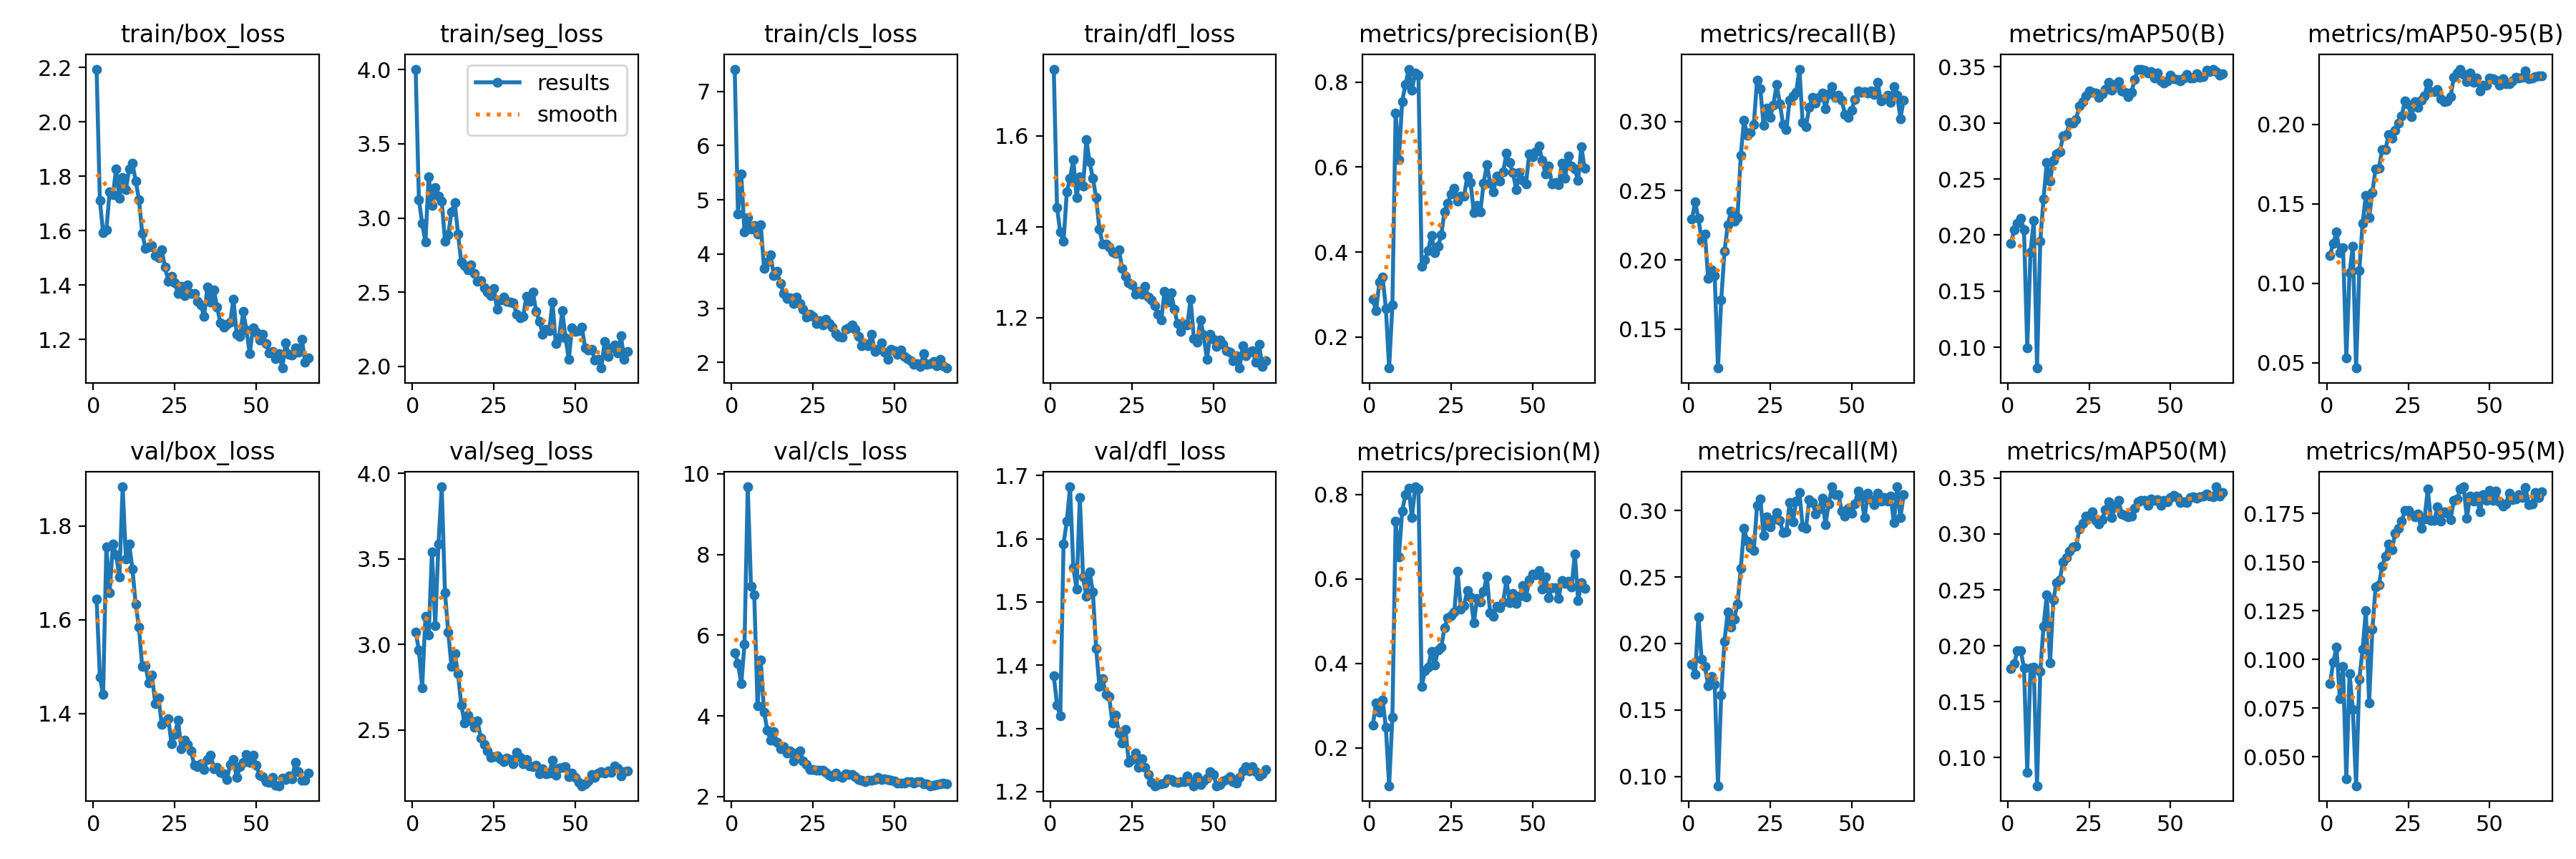

In [10]:
from IPython.display import display
from PIL import Image

run_dir = OUT_DIR / "yolov8s-seg-weeds"
img = run_dir / "results.png"
if img.exists():
    display(Image.open(img))
else:
    print("results.png not found yet:", img)


# Validate on val set (metrics + plots)

In [7]:
metrics = model.val(
    data=CFG["data"],
    project=str(OUT_DIR),
    name=f"{CFG['name']}-val",
    plots=True
)
metrics


Ultralytics 8.3.227  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
YOLOv8s-seg summary (fused): 85 layers, 11,780,374 parameters, 0 gradients, 39.9 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 2253.4214.8 MB/s, size: 5282.4 KB)
val: Scanning D:\Ai Systems Group\data\weeds_yolo_mask\labels\val.cache... 21 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 21/21  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 0.4it/s 5.3s15.2s
                   all         21       1428      0.586       0.32      0.348      0.237      0.545      0.307      0.329      0.186
                  weed         21        570      0.636      0.556      0.595       0.42      0.643      0.547      0.585      0.346
                  rose         21        858      0.536     0.0835      0.101     0.0538      0.446     0.0676     0.0736     0.0255
Spee

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001FD1BE7A4D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004

# Predict on some images

In [8]:
VAL_IMAGES = Path(ds["path"]) / ds["val"]  # images/val folder
pred = model.predict(
    source=str(VAL_IMAGES),
    project=str(OUT_DIR),
    name=f"{CFG['name']}-pred",
    save=True,      # save images with drawn boxes
    save_txt=True,  # save YOLO txt predictions
    conf=0.25       # tweak for precision/recall trade-off
)
pred[:2]



image 1/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0193.JPG: 736x1280 17 weeds, 3 roses, 103.7ms
image 2/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0194.JPG: 736x1280 15 weeds, 4 roses, 26.6ms
image 3/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0201.JPG: 736x1280 28 weeds, 5 roses, 26.9ms
image 4/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0203.JPG: 736x1280 37 weeds, 4 roses, 23.9ms
image 5/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0204.JPG: 736x1280 32 weeds, 8 roses, 23.0ms
image 6/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0207.JPG: 736x1280 26 weeds, 6 roses, 24.9ms
image 7/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0215.JPG: 736x1280 35 weeds, 8 roses, 23.9ms
image 8/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0217.JPG: 736x1280 40 weeds, 5 roses, 24.7ms
image 9/21 D:\Ai Systems Group\data\weeds_yolo_mask\images\val\DJI_0218.JPG: 736x1280 22 weeds, 7 rose

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: 'weed', 1: 'rose'}
 obb: None
 orig_img: array([[[110, 112, 122],
         [ 88,  90, 100],
         [ 87,  89, 100],
         ...,
         [104, 105, 115],
         [105, 107, 117],
         [108, 110, 120]],
 
        [[115, 117, 127],
         [ 91,  93, 103],
         [ 89,  91, 101],
         ...,
         [ 96,  97, 107],
         [ 98, 100, 110],
         [103, 105, 115]],
 
        [[119, 121, 131],
         [ 95,  97, 107],
         [ 89,  91, 101],
         ...,
         [107, 108, 118],
         [106, 108, 118],
         [100, 102, 112]],
 
        ...,
 
        [[140, 143, 148],
         [136, 139, 144],
         [136, 138, 146],
         ...,
         [128, 131, 139],
         [126, 129, 137],
         [134, 137, 145]],
 
        [[144, 142, 148],
         [140, 138, 144],
         [136,